In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE


import xgboost as xgb
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd
import math

from helper import util_two_class

Using TensorFlow backend.


# 0. Get Count Data

In [2]:
# get folder name
folder_name = '/path/to/9_FINAL/data/machine_learning/count_based/cross_validation/validation/validation_'

In [7]:
# loop through all folders
for i in range(0,5):
    
    normal_distribution_data = pd.DataFrame()
    
    # loop through all but current index and get fraction of data
    for j in range(0,5):
        if j != i:
            # get specific folder
            folder_name_specific = folder_name + str(j) + '.csv'
        
            # get data 
            data = pd.read_csv(folder_name_specific, sep=";",
                          index_col=0)
            
            # divide data to get distribution
            data_positive = data[data.label == 1]
            data_negative = data[data.label == 0]
            
            # get 20% of the data
            frac_positive = math.ceil(0.2*len(data_positive))
            frac_negative = math.ceil(0.2*len(data_negative))

            data_positive = data_positive.sample(frac_positive)
            data_negative = data_negative.sample(frac_negative)
        
            # concat data to data frame
            normal_distribution_data = pd.concat([data_positive,
                                                 data_negative,
                                                 normal_distribution_data])
    
    # shuffle data
    normal_distribution_data = normal_distribution_data.sample(frac=1).reset_index(drop=True)
    print(len(normal_distribution_data))
    print(normal_distribution_data.label.value_counts())
    
    # export data
    normal_distribution_data.to_csv('/path/to/9_FINAL/data/machine_learning/count_based/cross_validation/training_SMOTE/training_' + str(i) + '.csv',
                                   sep=";", index=False)
    

/home/linda/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


1058289
0    1040009
1      18280
Name: label, dtype: int64
1058289
0    1040009
1      18280
Name: label, dtype: int64
1058289
0    1040009
1      18280
Name: label, dtype: int64
1058289
0    1040009
1      18280
Name: label, dtype: int64
1058288
0    1040008
1      18280
Name: label, dtype: int64


In [2]:
# folder train
folder_train = '/path/to/9_FINAL/data/machine_learning/count_based/cross_validation/training_SMOTE/training_'

In [3]:
# validation folder
folder_validation = '/path/to/9_FINAL/data/machine_learning/count_based/cross_validation/validation/validation_'

In [10]:
# get goldstandard
validation_fold_0 = pd.read_csv(folder_validation+'0.csv',
                               sep=";", index_col=0)
validation_fold_0

/home/linda/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,instance,class,frequency,pidspread,pldspread,id,pids,p1,p10,p11,...,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d,label
0,cuxhaven,channel,1,1,1,343190981,['p23b'],0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,opioid,vasodilator,1,1,1,453050043,['p5'],0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,industry,estuary,2,1,2,344166346,['p3a'],0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,screenwriting,art,17,3,16,240868865,"['p8ap3a', 'p8a', 'p3a', 'p8a', 'p20c', 'p8a',...",0,0,0,...,0,0,0,0,0,6,0,0,0,1
4,stick,monument,3,3,3,297345077,"['p21a', 'p8b', 'p8a']",0,0,0,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322851,kempe,line,1,1,1,203939908,['p3a'],0,0,0,...,0,0,0,0,0,0,0,0,0,0
1322852,widow,giant,1,1,1,376449341,['p5'],0,0,0,...,0,0,1,0,0,0,0,0,0,0
1322853,territory,seabird,2,1,2,28222046,['p3a'],0,0,0,...,0,0,0,0,0,0,0,0,0,0
1322854,friday,filter,1,1,1,393022542,['p21a'],0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# get labels
validation_fold_0.label.value_counts()

0    1300010
1      22846
Name: label, dtype: int64

In [7]:
# get goldstandard
goldstandard = pd.read_csv('/path/to/9_FINAL/data/goldstandard/goldstandard_count.csv',
                          sep=";", index_col=0)
goldstandard.drop(columns={'instance', 'class', 'modifications'}, inplace=True)
goldstandard

,_id,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,141663461,3,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,147713771,3,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,270852864,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,516170918,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,387574181,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,420639686,2,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
135,199660983,3,3,3,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
136,218064825,5,2,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137,89573263,2,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0


In [4]:
# get labels of goldstandard
goldstandard_labels = pd.read_csv('/path/to/9_FINAL/data/goldstandard/goldstandard_raw.csv',
                          sep=";", index_col=0)
# rename columns
goldstandard_labels.columns = ['_id', 'label']
goldstandard = pd.merge(goldstandard, goldstandard_labels,
                       how='left', left_on='_id',
                       right_on='_id')
goldstandard.head()

In [11]:
# get the difference of columns between goldstandard and validation set
validation_fold_0.columns 

Index(['instance', 'class', 'frequency', 'pidspread', 'pldspread', 'id',
       'pids', 'p1', 'p10', 'p11', 'p12a', 'p12b', 'p12c', 'p13', 'p14',
       'p15a', 'p15b', 'p16', 'p2', 'p20a', 'p20b', 'p20c', 'p20d', 'p21a',
       'p21b', 'p21c', 'p21d', 'p22a', 'p22b', 'p23a', 'p23b', 'p23c', 'p23d',
       'p23e', 'p24', 'p25', 'p26', 'p27a', 'p27b', 'p28a', 'p28b', 'p28c',
       'p28d', 'p29a', 'p29c', 'p30a', 'p30b', 'p31a', 'p31b', 'p34', 'p36',
       'p37', 'p38', 'p39', 'p3a', 'p4', 'p42', 'p43', 'p5', 'p6', 'p7', 'p8a',
       'p8b', 'p8c', 'p8d', 'label'],
      dtype='object')

In [12]:
goldstandard.columns

Index(['_id', 'frequency', 'pidspread', 'pldspread', 'p1', 'p10', 'p11',
       'p12a', 'p12b', 'p12c', 'p13', 'p14', 'p15a', 'p15b', 'p16', 'p2',
       'p20a', 'p20b', 'p20c', 'p20d', 'p21a', 'p21b', 'p21c', 'p21d', 'p22a',
       'p22b', 'p23a', 'p23b', 'p23c', 'p23d', 'p23e', 'p24', 'p25', 'p26',
       'p27a', 'p27b', 'p28a', 'p28b', 'p28c', 'p28d', 'p29a', 'p29c', 'p30a',
       'p30b', 'p31a', 'p31b', 'p34', 'p36', 'p37', 'p38', 'p39', 'p3a', 'p4',
       'p42', 'p43', 'p5', 'p6', 'p7', 'p8a', 'p8b', 'p8c', 'p8d', 'label'],
      dtype='object')

In [13]:
# get pid column with 0 for the columns without values
pad_with_zeros = [0] * len(goldstandard)

In [14]:
# get difference
difference = list(set(validation_fold_0.columns.to_list()) - set(goldstandard.columns.to_list()))
difference.sort()
difference

['class', 'id', 'instance', 'pids']

## 0.1 Logistic Regression

In [4]:
lr = LogisticRegression(random_state=42)
util_two_class.cross_validation(folder_validation, folder_train,
                ['instance', 'class', 'id', 'pids',
                'frequency', 'pidspread', 'pldspread'],
                lr, sample=True)

/home/linda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[1288722   11288]
 [  21568    1278]]
Precision 0.10170300811714149 and Recall 0.055939770638186115 and F1 0.0721789223991867
----------------------------------


/home/linda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[1286567   13443]
 [  21424    1422]]
Precision 0.09566094853683148 and Recall 0.06224284338615075 and F1 0.0754156612129087
----------------------------------


/home/linda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[1285518   14492]
 [  21439    1407]]
Precision 0.0884961318321907 and Recall 0.061586273308237766 and F1 0.07262872628726287
----------------------------------


/home/linda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[1287473   12537]
 [  21594    1252]]
Precision 0.09079701211110305 and Recall 0.054801715836470276 and F1 0.06834993858332196
----------------------------------


/home/linda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[1286322   13690]
 [  21510    1339]]
Precision 0.08909441745957815 and Recall 0.05860212700774651 and F1 0.07070067057394792
----------------------------------
---------------------
Overall Precision: 0.09315030361136897
Overall Recall: 0.05863454603535828
Overall F1: 0.07185478381132562
---------------------
Negative Precision: 0.9835627333013118
Negative Recall: 0.9899308499259766
Negative F1: 0.986736327405642


In [18]:
lr = LogisticRegression(random_state=42)
train = folder_train = pd.read_csv('/path/to/9_FINAL/data/machine_learning/count_based/cross_validation/training_SMOTE/training_0.csv',
                                   sep=";")
train.head()

,instance,class,frequency,pidspread,pldspread,id,pids,p1,p10,p11,...,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d,label
0,nanomaterial,project,2,2,2,110282739,"['p34', 'p3a']",0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,logo,property,548,16,459,457566109,"['p6p5p4p1p28dp3a', 'p5p4p1p25p8ap3a', 'p6p26p...",54,0,0,...,0,0,9,2,0,21,0,3,0,0
2,moon,castle,2,2,2,307314511,"['p2', 'p8a']",0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,bible,murderer,7,2,6,298667504,"['p8b', 'p8a', 'p8a', 'p8a', 'p8a']",0,0,0,...,0,0,0,0,0,4,1,0,0,0
4,man,glassware,1,1,1,264243113,['p28b'],0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
train_new = train.drop(columns=['frequency', 'pidspread', 
                                'pldspread', 'id', 'pids', 'instance',
                               'class'])
y_train = train_new['label'].to_list()
X_train = train_new.drop(columns=['label'])
oversample = SMOTE(sampling_strategy=0.1,
                          k_neighbors=5)
X_train, y_train = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_train

,p1,p10,p11,p12a,p12b,p12c,p13,p14,p15a,p15b,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,5,10,0,0,0,0,0,0,0,0,...,0,0,0,13,0,0,16,11,0,0
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
311996,19,0,0,0,0,0,0,0,0,0,...,1,0,0,7,0,0,25,3,4,1
311997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
311998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0


In [22]:
# fit model
lr.fit(X_train, y_train)
goldstandard_new = goldstandard.drop(columns=['frequency', 'pidspread', 'pldspread', '_id'])
y_gold = goldstandard_new['label'].to_list()
X_gold = goldstandard_new.drop(columns=['label'])
X_gold

/home/linda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,p1,p10,p11,p12a,p12b,p12c,p13,p14,p15a,p15b,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
135,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
136,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0


In [23]:
# predict
predictions = lr.predict(X_gold)

In [24]:
# get metrics
print(f'Precision {precision_score(y_gold, predictions)}, Recall {recall_score(y_gold, predictions)}, F1 {f1_score(y_gold, predictions)}')

Precision 0.0, Recall 0.0, F1 0.0


/home/linda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# flip labels
conf_matrix = confusion_matrix(y_gold, predictions)
precision = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
recall = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
f1 = (2*precision*recall)/(precision+recall)
print(f'Precision {precision}, Recall {recall}, F1 {f1}')

Precision 0.9640287769784173, Recall 1.0, F1 0.9816849816849816


## 0.2 Naive Bayes

In [5]:
nb = MultinomialNB()
util_two_class.cross_validation(folder_validation, folder_train,
                ['instance', 'class', 'id', 'pids'],
                nb, sample=True)

[[1268120   31890]
 [  20562    2284]]
Precision 0.06683443553578744 and Recall 0.09997373719688347 and F1 0.0801122413188355
----------------------------------
[[1271723   28287]
 [  20761    2085]]
Precision 0.06864875543263532 and Recall 0.09126324082990458 and F1 0.07835694689766622
----------------------------------
[[1270977   29033]
 [  20863    1983]]
Precision 0.0639347433582667 and Recall 0.0867985643000963 and F1 0.07363261668708922
----------------------------------
[[1269371   30639]
 [  20722    2124]]
Precision 0.0648292280926655 and Recall 0.09297032303247833 and F1 0.0763905123271413
----------------------------------
[[1272162   27850]
 [  20949    1900]]
Precision 0.06386554621848739 and Recall 0.08315462383474112 and F1 0.07224471948135895
----------------------------------
---------------------
Overall Precision: 0.06562254172756847
Overall Recall: 0.09083209783882076
Overall F1: 0.07614740734241823
---------------------
Negative Precision: 0.9839137177542963
Negat

In [26]:
train_new = train.drop(columns=['id', 'pids', 'instance',
                               'class'])
y_train = train_new['label'].to_list()
X_train = train_new.drop(columns=['label'])
oversample = SMOTE(sampling_strategy=0.1,
                          k_neighbors=5)
X_train, y_train = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_train

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,44,11,39,1,0,0,0,0,0,0,...,0,0,0,4,0,0,5,1,2,0
1,1,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,2,5,0,0,0,0,0,0,0,...,0,0,0,3,0,0,2,0,0,0
4,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311995,3,3,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
311996,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
311997,2,2,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
311998,8,4,8,0,0,0,0,0,0,0,...,0,0,0,2,0,0,1,0,0,0


In [28]:
# fit model
nb = MultinomialNB()
nb.fit(X_train, y_train)
goldstandard_new = goldstandard.drop(columns=['_id'])
y_gold = goldstandard_new['label'].to_list()
X_gold = goldstandard_new.drop(columns=['label'])
X_gold

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,3,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,3,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
135,3,3,3,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
136,5,2,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0


In [30]:
# predict
predictions = nb.predict(X_gold)

In [31]:
# get metrics
print(f'Precision {precision_score(y_gold, predictions)}, Recall {recall_score(y_gold, predictions)}, F1 {f1_score(y_gold, predictions)}')

Precision 0.0, Recall 0.0, F1 0.0


In [32]:
# flip labels
conf_matrix = confusion_matrix(y_gold, predictions)
precision = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
recall = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
f1 = (2*precision*recall)/(precision+recall)
print(f'Precision {precision}, Recall {recall}, F1 {f1}')

Precision 0.9637681159420289, Recall 0.9925373134328358, F1 0.9779411764705882


In [33]:
conf_matrix

array([[133,   1],
       [  5,   0]])

## 0.3 XGBoost

In [4]:
xg = xgb.XGBRFClassifier(random_state=42)
util_two_class.cross_validation(folder_validation, folder_train,
                ['instance', 'class', 'id', 'pids'],
                xg, sample=True)

[[1198156  101854]
 [  17225    5621]]
Precision 0.05230053500814143 and Recall 0.24603869386325833 and F1 0.08626391755741593
----------------------------------
[[1189087  110923]
 [  17100    5746]]
Precision 0.04925044356255732 and Recall 0.25151011117919986 and F1 0.0823710712109809
----------------------------------
[[1197602  102408]
 [  17432    5414]]
Precision 0.05021238708241361 and Recall 0.23697802678805918 and F1 0.08286650136223099
----------------------------------
[[1199838  100172]
 [  17481    5365]]
Precision 0.050835252091683485 and Recall 0.2348332312002101 and F1 0.08357804382200135
----------------------------------
[[1188957  111055]
 [  17067    5782]]
Precision 0.0494877478880834 and Recall 0.25305265000656485 and F1 0.08278567644574258
----------------------------------
---------------------
Overall Precision: 0.050417273126575846
Overall Recall: 0.24448254260745847
Overall F1: 0.08357304207967435
---------------------
Negative Precision: 0.9857583908403535
N

In [34]:
train_new = train.drop(columns=['id', 'pids', 'instance',
                               'class'])
y_train = train_new['label'].to_list()
X_train = train_new.drop(columns=['label'])
oversample = SMOTE(sampling_strategy=0.1,
                          k_neighbors=5)
X_train, y_train = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_train

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,1,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,3,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311995,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
311996,119,10,14,0,0,0,0,0,0,0,...,1,0,0,36,0,0,1,0,0,0
311997,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
311998,11,2,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,3,0,0


In [35]:
# fit model
xg = xgb.XGBRFClassifier(random_state=42)
xg.fit(X_train, y_train)
goldstandard_new = goldstandard.drop(columns=['_id'])
y_gold = goldstandard_new['label'].to_list()
X_gold = goldstandard_new.drop(columns=['label'])
X_gold

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,3,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,3,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
135,3,3,3,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
136,5,2,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0


In [36]:
# predict
predictions = xg.predict(X_gold)

In [37]:
# get metrics
print(f'Precision {precision_score(y_gold, predictions)}, Recall {recall_score(y_gold, predictions)}, F1 {f1_score(y_gold, predictions)}')

Precision 0.25, Recall 0.2, F1 0.22222222222222224


In [38]:
# flip labels
conf_matrix = confusion_matrix(y_gold, predictions)
precision = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
recall = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
f1 = (2*precision*recall)/(precision+recall)
print(f'Precision {precision}, Recall {recall}, F1 {f1}')

Precision 0.9703703703703703, Recall 0.9776119402985075, F1 0.9739776951672863


In [39]:
conf_matrix

array([[131,   3],
       [  4,   1]])

## 0.4 Random Forest

In [5]:
rf = RandomForestClassifier(random_state=42)
util_two_class.cross_validation(folder_validation, folder_train,
                ['instance', 'class', 'id', 'pids'],
                rf, sample=True)

[[1220413   79597]
 [  18613    4233]]
Precision 0.0504950495049505 and Recall 0.1852840759870437 and F1 0.07936180584198882
----------------------------------
[[1217935   82075]
 [  18567    4279]]
Precision 0.04955184473214906 and Recall 0.18729755755931016 and F1 0.07836996336996337
----------------------------------
[[1220241   79769]
 [  18612    4234]]
Precision 0.05040296179898337 and Recall 0.18532784732557123 and F1 0.07925202856367397
----------------------------------
[[1220258   79752]
 [  18697    4149]]
Precision 0.049451138842206886 and Recall 0.18160728355073097 and F1 0.07773520567322735
----------------------------------
[[1224749   75263]
 [  18669    4180]]
Precision 0.05261634127613509 and Recall 0.1829401724364305 and F1 0.08172682125679427
----------------------------------
---------------------
Overall Precision: 0.05050346723088498
Overall Recall: 0.1844913873718173
Overall F1: 0.07928916494112956
---------------------
Negative Precision: 0.9849666386899987
Neg

In [40]:
train_new = train.drop(columns=['id', 'pids', 'instance',
                               'class'])
y_train = train_new['label'].to_list()
X_train = train_new.drop(columns=['label'])
oversample = SMOTE(sampling_strategy=0.1,
                          k_neighbors=5)
X_train, y_train = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_train

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2,1,2,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
2,2,2,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311995,32,9,27,2,2,0,0,0,0,0,...,0,0,0,4,0,0,2,5,0,0
311996,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
311997,2,1,2,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
311998,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# fit model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [43]:
# predict
predictions = rf.predict(X_gold)

In [44]:
# get metrics
print(f'Precision {precision_score(y_gold, predictions)}, Recall {recall_score(y_gold, predictions)}, F1 {f1_score(y_gold, predictions)}')

Precision 0.2857142857142857, Recall 0.4, F1 0.3333333333333333


In [45]:
# flip labels
conf_matrix = confusion_matrix(y_gold, predictions)
precision = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
recall = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
f1 = (2*precision*recall)/(precision+recall)
print(f'Precision {precision}, Recall {recall}, F1 {f1}')

Precision 0.9772727272727273, Recall 0.9626865671641791, F1 0.9699248120300752


## 0.5 MLPClassifier

In [6]:
nnet = MLPClassifier(random_state=42)
util_two_class.cross_validation(folder_validation, folder_train,
                ['instance', 'class', 'id', 'pids'],
                nnet, sample=True)

[[1199289  100721]
 [  17680    5166]]
Precision 0.04878785875508797 and Recall 0.2261227348332312 and F1 0.08025914101279392
----------------------------------
[[1240606   59404]
 [  18995    3851]]
Precision 0.060880562801359575 and Recall 0.1685634246695264 and F1 0.08945308416859271
----------------------------------
[[1230931   69079]
 [  18785    4061]]
Precision 0.055523653267705766 and Recall 0.17775540576030815 and F1 0.08461650657387536
----------------------------------
[[1204480   95530]
 [  17668    5178]]
Precision 0.051415974897724114 and Recall 0.2266479908955616 and F1 0.08381760202016932
----------------------------------
[[1224356   75656]
 [  18362    4487]]
Precision 0.055987422482312865 and Recall 0.19637620902446495 and F1 0.08713298120242349
----------------------------------
---------------------
Overall Precision: 0.054519094440838065
Overall Recall: 0.19909315303661845
Overall F1: 0.08505586299557095
---------------------
Negative Precision: 0.985225664885882

In [46]:
train_new = train.drop(columns=['id', 'pids', 'instance',
                               'class'])
y_train = train_new['label'].to_list()
X_train = train_new.drop(columns=['label'])
oversample = SMOTE(sampling_strategy=0.1,
                          k_neighbors=5)
X_train, y_train = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_train

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,2,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
4,3,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311995,6,2,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,0,0,0
311996,48,9,42,5,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
311997,2,2,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
311998,13,5,13,0,0,0,0,0,0,0,...,0,0,0,1,0,0,6,0,1,0


In [48]:
# fit model
nnet = MLPClassifier(random_state=42)
nnet.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [49]:
# predict
predictions = nnet.predict(X_gold)

In [50]:
# get metrics
print(f'Precision {precision_score(y_gold, predictions)}, Recall {recall_score(y_gold, predictions)}, F1 {f1_score(y_gold, predictions)}')

Precision 0.2857142857142857, Recall 0.4, F1 0.3333333333333333


In [51]:
# flip labels
conf_matrix = confusion_matrix(y_gold, predictions)
precision = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
recall = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
f1 = (2*precision*recall)/(precision+recall)
print(f'Precision {precision}, Recall {recall}, F1 {f1}')

Precision 0.9772727272727273, Recall 0.9626865671641791, F1 0.9699248120300752


## 0.6 Decision Tree Classifier

In [7]:
dt = DecisionTreeClassifier(random_state=42)
util_two_class.cross_validation(folder_validation, folder_train,
                ['instance', 'class', 'id', 'pids'],
                dt, sample=True)

[[1189064  110946]
 [  18272    4574]]
Precision 0.03959487534626039 and Recall 0.20021010242493215 and F1 0.06611450789933944
----------------------------------
[[1190333  109677]
 [  18394    4452]]
Precision 0.03900849039245065 and Recall 0.19486999912457323 and F1 0.0650045628764373
----------------------------------
[[1197707  102303]
 [  18475    4371]]
Precision 0.0409753079475786 and Recall 0.19132452070384312 and F1 0.06749536751080913
----------------------------------
[[1192339  107671]
 [  18429    4417]]
Precision 0.039406537720362574 and Recall 0.19333800227610962 and F1 0.06546904412527607
----------------------------------
[[1194339  105673]
 [  18279    4570]]
Precision 0.04145387915786036 and Recall 0.20000875311829838 and F1 0.06867430048387582
----------------------------------
---------------------
Overall Precision: 0.04008781811290252
Overall Recall: 0.1959502755295513
Overall F1: 0.06655155657914755
---------------------
Negative Precision: 0.9848324586105459
Ne

In [52]:
train_new = train.drop(columns=['id', 'pids', 'instance',
                               'class'])
y_train = train_new['label'].to_list()
X_train = train_new.drop(columns=['label'])
oversample = SMOTE(sampling_strategy=0.1,
                          k_neighbors=5)
X_train, y_train = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_train

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,32,6,27,0,0,0,0,0,0,0,...,0,0,0,7,0,0,5,1,6,0
1,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,33,9,28,0,0,0,0,0,0,0,...,0,0,2,1,0,0,14,5,0,0
4,5,2,5,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311995,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
311996,92,13,80,1,0,0,0,0,0,0,...,0,0,1,10,0,0,26,2,1,0
311997,6,1,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,0,0,0
311998,10,4,8,2,0,0,0,0,0,0,...,0,0,0,2,0,0,2,0,0,0


In [53]:
# fit model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [54]:
# predict
predictions = dt.predict(X_gold)

In [55]:
# get metrics
print(f'Precision {precision_score(y_gold, predictions)}, Recall {recall_score(y_gold, predictions)}, F1 {f1_score(y_gold, predictions)}')

Precision 0.2, Recall 0.2, F1 0.20000000000000004


In [56]:
# flip labels
conf_matrix = confusion_matrix(y_gold, predictions)
precision = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
recall = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
f1 = (2*precision*recall)/(precision+recall)
print(f'Precision {precision}, Recall {recall}, F1 {f1}')

Precision 0.9701492537313433, Recall 0.9701492537313433, F1 0.9701492537313433


# 1. Get One Hot Data

In [2]:
# get folder name
folder_name = '/path/to/9_FINAL/data/machine_learning/two_class/one-hot-ecoding/train/cross_validation/validation/val_fold_'
count_folder = '/path/to/9_FINAL/data/machine_learning/count_based/cross_validation/training_SMOTE/training_'

In [3]:
# loop through all folders
for i in range(0,5):
    
    normal_distribution_data = pd.DataFrame()
    
    # loop through all but current index and get fraction of data
    for j in range(0,5):
        
        # get training fold from count based features
        count_folder_specific = count_folder + str(i) + '.csv'
        counts = pd.read_csv(count_folder_specific, sep=";")
        counts = counts.id.to_list()
        print(f'Length of Counts {len(counts)}')
        
        # get ids of validation fold
        validation_data_folder = folder_name + str(j) + '.csv'
        validation_data = pd.read_csv(validation_data_folder, sep=";", index_col=0)
        
        # get validation data with overlap with counts
        validation_data = validation_data[validation_data.id.isin(counts)]
        
        # stack with normal_distribution_data
        normal_distribution_data = pd.concat([normal_distribution_data,
                                             validation_data])
        print(len(normal_distribution_data))
        
    # shuffle data
    normal_distribution_data = normal_distribution_data.sample(frac=1).reset_index(drop=True)
    print(normal_distribution_data.head())
    print(len(normal_distribution_data))
    print('------------------------------------')
    
    # export data
    normal_distribution_data.to_csv('/path/to/9_FINAL/data/machine_learning/two_class/one-hot-ecoding/train/cross_validation/train_SMOTE/train_' + str(i) + '.csv',
                                   sep=";", index=False)
    

Length of Counts 1058289


/home/linda/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


0
Length of Counts 1058289
264572
Length of Counts 1058289
529144
Length of Counts 1058289
793716
Length of Counts 1058289
1058289
   instance     class  frequency  pidspread  pldspread         id     pids  \
0  solstice  birthday          3          1          3   57667952   ['p5']   
1   diamond    cherry          1          1          1  272611610  ['p8a']   
2    franca  musician          1          1          1   99193718  ['p8a']   
3     herat   village          1          1          1  231282697   ['p1']   
4      ekta     actor          3          1          1   90369715  ['p25']   

   p1  p10  p11  ...  p42  p43  p5  p6  p7  p8a  p8b  p8c  p8d  label  
0   0    0    0  ...    0    0   1   0   0    0    0    0    0      0  
1   0    0    0  ...    0    0   0   0   0    1    0    0    0      0  
2   0    0    0  ...    0    0   0   0   0    1    0    0    0      0  
3   1    0    0  ...    0    0   0   0   0    0    0    0    0      0  
4   0    0    0  ...    0    0   0   0  

In [2]:
# folder train
folder_train = '/path/to/9_FINAL/data/machine_learning/two_class/one-hot-ecoding/train/cross_validation/train_SMOTE/train_'

In [5]:
# folder validation
folder_validation = '/path/to/9_FINAL/data/machine_learning/two_class/one-hot-ecoding/train/cross_validation/validation/val_fold_'

In [6]:
# get goldstandard
validation_fold_0 = pd.read_csv(folder_validation+'0.csv',
                               sep=";", index_col=0)
validation_fold_0

/home/linda/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,instance,class,frequency,pidspread,pldspread,id,pids,p1,p10,p11,...,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d,label
0,cuxhaven,channel,1,1,1,343190981,['p23b'],0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,opioid,vasodilator,1,1,1,453050043,['p5'],0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,industry,estuary,2,1,2,344166346,['p3a'],0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,screenwriting,art,17,3,16,240868865,"['p8ap3a', 'p8a', 'p3a', 'p8a', 'p20c', 'p8a',...",0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,stick,monument,3,3,3,297345077,"['p21a', 'p8b', 'p8a']",0,0,0,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322851,kempe,line,1,1,1,203939908,['p3a'],0,0,0,...,0,0,0,0,0,0,0,0,0,0
1322852,widow,giant,1,1,1,376449341,['p5'],0,0,0,...,0,0,1,0,0,0,0,0,0,0
1322853,territory,seabird,2,1,2,28222046,['p3a'],0,0,0,...,0,0,0,0,0,0,0,0,0,0
1322854,friday,filter,1,1,1,393022542,['p21a'],0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# get labels
validation_fold_0.label.value_counts()

0    1300010
1      22846
Name: label, dtype: int64

In [8]:
# get goldstandard
goldstandard = pd.read_csv('/path/to/9_FINAL/data/goldstandard/goldstandard_one_hot.csv',
                          sep=";", index_col=0)
goldstandard.drop(columns={'instance', 'class', 'modifications'}, inplace=True)
goldstandard

,_id,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,141663461,3,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,147713771,3,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,270852864,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,516170918,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,387574181,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,420639686,2,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
135,199660983,3,3,3,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
136,218064825,5,2,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137,89573263,2,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [9]:
# merge labels to goldstandard
goldstandard = pd.merge(goldstandard, goldstandard_labels,
                       how='left', left_on='_id',
                       right_on='_id')
goldstandard.head()

,_id,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,...,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d,label
0,141663461,3,2,3,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,147713771,3,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,270852864,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,516170918,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,387574181,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [10]:
# get the difference of columns between goldstandard and validation set
validation_fold_0.columns 

Index(['instance', 'class', 'frequency', 'pidspread', 'pldspread', 'id',
       'pids', 'p1', 'p10', 'p11', 'p12a', 'p12b', 'p12c', 'p13', 'p14',
       'p15a', 'p15b', 'p16', 'p2', 'p20a', 'p20b', 'p20c', 'p20d', 'p21a',
       'p21b', 'p21c', 'p21d', 'p22a', 'p22b', 'p23a', 'p23b', 'p23c', 'p23d',
       'p23e', 'p24', 'p25', 'p26', 'p27a', 'p27b', 'p28a', 'p28b', 'p28c',
       'p28d', 'p29a', 'p29c', 'p30a', 'p30b', 'p31a', 'p31b', 'p34', 'p36',
       'p37', 'p38', 'p39', 'p3a', 'p4', 'p42', 'p43', 'p5', 'p6', 'p7', 'p8a',
       'p8b', 'p8c', 'p8d', 'label'],
      dtype='object')

In [11]:
goldstandard.columns

Index(['_id', 'frequency', 'pidspread', 'pldspread', 'p1', 'p10', 'p11',
       'p12a', 'p12b', 'p12c', 'p13', 'p14', 'p15a', 'p15b', 'p16', 'p2',
       'p20a', 'p20b', 'p20c', 'p20d', 'p21a', 'p21b', 'p21c', 'p21d', 'p22a',
       'p22b', 'p23a', 'p23b', 'p23c', 'p23d', 'p23e', 'p24', 'p25', 'p26',
       'p27a', 'p27b', 'p28a', 'p28b', 'p28c', 'p28d', 'p29a', 'p29c', 'p30a',
       'p30b', 'p31a', 'p31b', 'p34', 'p36', 'p37', 'p38', 'p39', 'p3a', 'p4',
       'p42', 'p43', 'p5', 'p6', 'p7', 'p8a', 'p8b', 'p8c', 'p8d', 'label'],
      dtype='object')

In [12]:
# get difference
difference = list(set(validation_fold_0.columns.to_list()) - set(goldstandard.columns.to_list()))
difference.sort()
difference

['class', 'id', 'instance', 'pids']

## 1.1 Logistic Regression

In [8]:
lr = LogisticRegression(random_state=42)
util_two_class.cross_validation(folder_validation, folder_train,
                ['instance', 'class', 'id', 'pids'],
                lr, sample=True)

/home/linda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[1285532   14478]
 [  21284    1562]]
Precision 0.09738154613466334 and Recall 0.06837083078000525 and F1 0.08033739649231084
----------------------------------


/home/linda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[1286911   13099]
 [  21429    1417]]
Precision 0.09761642325709562 and Recall 0.06202398669351309 and F1 0.07585247042449547
----------------------------------


/home/linda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[1283936   16074]
 [  21313    1533]]
Precision 0.08706764355086045 and Recall 0.06710146196270682 and F1 0.0757916594566534
----------------------------------


/home/linda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[1282811   17199]
 [  21175    1671]]
Precision 0.08855325914149444 and Recall 0.07314190667950626 and F1 0.08011314603509445
----------------------------------


/home/linda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[1283165   16847]
 [  21276    1573]]
Precision 0.08539630836047774 and Recall 0.06884327541686726 and F1 0.07623155395090747
----------------------------------
---------------------
Overall Precision: 0.0912030360889183
Overall Recall: 0.06789629230651974
Overall F1: 0.07766524527189232
---------------------
Negative Precision: 0.9836913048927013
Negative Recall: 0.9880467113204086
Negative F1: 0.9858638242025819


In [13]:
lr = LogisticRegression(random_state=42)
train = folder_train = pd.read_csv('/path/to/9_FINAL/data/machine_learning/two_class/one-hot-ecoding/train/cross_validation/train_SMOTE/train_0.csv',
                                   sep=";")
train.head()

,instance,class,frequency,pidspread,pldspread,id,pids,p1,p10,p11,...,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d,label
0,solstice,birthday,3,1,3,57667952,['p5'],0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,diamond,cherry,1,1,1,272611610,['p8a'],0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,franca,musician,1,1,1,99193718,['p8a'],0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,herat,village,1,1,1,231282697,['p1'],1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ekta,actor,3,1,1,90369715,['p25'],0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
train_new = train.drop(columns=['id', 'pids', 'instance',
                               'class'])
y_train = train_new['label'].to_list()
X_train = train_new.drop(columns=['label'])
oversample = SMOTE(sampling_strategy=0.1,
                          k_neighbors=5)
X_train, y_train = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_train

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,2,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,18,2,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311995,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
311996,33,7,28,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
311997,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
311998,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# fit model
lr.fit(X_train, y_train)
goldstandard_new = goldstandard.drop(columns=['_id'])
y_gold = goldstandard_new['label'].to_list()
X_gold = goldstandard_new.drop(columns=['label'])
X_gold

/home/linda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,3,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,3,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
135,3,3,3,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
136,5,2,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [17]:
# predict
predictions = lr.predict(X_gold)

In [18]:
# get metrics
print(f'Precision {precision_score(y_gold, predictions)}, Recall {recall_score(y_gold, predictions)}, F1 {f1_score(y_gold, predictions)}')

Precision 0.3333333333333333, Recall 0.2, F1 0.25


In [19]:
# flip labels
conf_matrix = confusion_matrix(y_gold, predictions)
precision = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
recall = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
f1 = (2*precision*recall)/(precision+recall)
print(f'Precision {precision}, Recall {recall}, F1 {f1}')

Precision 0.9705882352941176, Recall 0.9850746268656716, F1 0.9777777777777777


## 1.2 Naive Bayes

In [9]:
nb = MultinomialNB()
util_two_class.cross_validation(folder_validation, folder_train,
                ['instance', 'class', 'id', 'pids'],
                nb, sample=True)

[[1268769   31241]
 [  20637    2209]]
Precision 0.0660388639760837 and Recall 0.09669088680731856 and F1 0.07847804462128748
----------------------------------
[[1272308   27702]
 [  20804    2042]]
Precision 0.06865250134480903 and Recall 0.0893810732732207 and F1 0.0776573493059517
----------------------------------
[[1271932   28078]
 [  20895    1951]]
Precision 0.06497052848912718 and Recall 0.08539788146721526 and F1 0.07379669030732862
----------------------------------
[[1270997   29013]
 [  20846    2000]]
Precision 0.06448908522232612 and Recall 0.08754267705506434 and F1 0.07426799606379621
----------------------------------
[[1271987   28025]
 [  20948    1901]]
Precision 0.06352335761545144 and Recall 0.0831983894262331 and F1 0.0720416864045476
----------------------------------
---------------------
Overall Precision: 0.06553486732955949
Overall Recall: 0.0884421816058104
Overall F1: 0.07524835334058232
---------------------
Negative Precision: 0.9838811694481013
Negati

In [20]:
train_new = train.drop(columns=['id', 'pids', 'instance',
                               'class'])
y_train = train_new['label'].to_list()
X_train = train_new.drop(columns=['label'])
oversample = SMOTE(sampling_strategy=0.1,
                          k_neighbors=5)
X_train, y_train = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_train

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,13,4,13,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
4,2,2,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311995,2,1,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
311996,1,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
311997,4,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
311998,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [22]:
# fit model
nb = MultinomialNB()
nb.fit(X_train, y_train)
goldstandard_new = goldstandard.drop(columns=['_id'])
y_gold = goldstandard_new['label'].to_list()
X_gold = goldstandard_new.drop(columns=['label'])
X_gold

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,3,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,3,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
135,3,3,3,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
136,5,2,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [23]:
# predict
predictions = nb.predict(X_gold)

In [24]:
# get metrics
print(f'Precision {precision_score(y_gold, predictions)}, Recall {recall_score(y_gold, predictions)}, F1 {f1_score(y_gold, predictions)}')

Precision 0.0, Recall 0.0, F1 0.0


In [25]:
# flip labels
conf_matrix = confusion_matrix(y_gold, predictions)
precision = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
recall = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
f1 = (2*precision*recall)/(precision+recall)
print(f'Precision {precision}, Recall {recall}, F1 {f1}')

Precision 0.9637681159420289, Recall 0.9925373134328358, F1 0.9779411764705882


## 1.3 XGBoost

In [10]:
xg = xgb.XGBRFClassifier(random_state=42)
util_two_class.cross_validation(folder_validation, folder_train,
                ['instance', 'class', 'id', 'pids'],
                xg, sample=True)

[[1200924   99086]
 [  17335    5511]]
Precision 0.05268793560044743 and Recall 0.2412238466252298 and F1 0.0864857230291189
----------------------------------
[[1182795  117215]
 [  16935    5911]]
Precision 0.04800773191689814 and Recall 0.25873238203624266 and F1 0.08098813471076644
----------------------------------
[[1183501  116509]
 [  16927    5919]]
Precision 0.04834678341555853 and Recall 0.2590825527444629 and F1 0.08148739623057119
----------------------------------
[[1201526   98484]
 [  17570    5276]]
Precision 0.05084811102544333 and Recall 0.23093758207125975 and F1 0.0833451811130594
----------------------------------
[[1198191  101821]
 [  17410    5439]]
Precision 0.05070855864255081 and Recall 0.23804105212481946 and F1 0.08360682197234627
----------------------------------
---------------------
Overall Precision: 0.050119824120179644
Overall Recall: 0.24560348312040295
Overall F1: 0.08318265141117244
---------------------
Negative Precision: 0.9857639490586759
Neg

In [26]:
train_new = train.drop(columns=['id', 'pids', 'instance',
                               'class'])
y_train = train_new['label'].to_list()
X_train = train_new.drop(columns=['label'])
oversample = SMOTE(sampling_strategy=0.1,
                          k_neighbors=5)
X_train, y_train = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_train

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,3,3,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311995,5,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
311996,3,2,3,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
311997,3,2,3,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
311998,19,6,18,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [27]:
# fit model
xg = xgb.XGBRFClassifier(random_state=42)
xg.fit(X_train, y_train)
goldstandard_new = goldstandard.drop(columns=['_id'])
y_gold = goldstandard_new['label'].to_list()
X_gold = goldstandard_new.drop(columns=['label'])
X_gold

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,3,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,3,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
135,3,3,3,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
136,5,2,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [28]:
# predict
predictions = xg.predict(X_gold)

In [29]:
# get metrics
print(f'Precision {precision_score(y_gold, predictions)}, Recall {recall_score(y_gold, predictions)}, F1 {f1_score(y_gold, predictions)}')

Precision 0.25, Recall 0.2, F1 0.22222222222222224


In [30]:
# flip labels
conf_matrix = confusion_matrix(y_gold, predictions)
precision = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
recall = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
f1 = (2*precision*recall)/(precision+recall)
print(f'Precision {precision}, Recall {recall}, F1 {f1}')

Precision 0.9703703703703703, Recall 0.9776119402985075, F1 0.9739776951672863


## 1.4 Random Forest

In [11]:
rf = RandomForestClassifier(random_state=42)
util_two_class.cross_validation(folder_validation, folder_train,
                ['instance', 'class', 'id', 'pids'],
                rf, sample=True)

[[1217233   82777]
 [  18490    4356]]
Precision 0.0499925401397863 and Recall 0.19066795062593014 and F1 0.07921512288709663
----------------------------------
[[1218364   81646]
 [  18529    4317]]
Precision 0.05021928038807394 and Recall 0.18896086842335638 and F1 0.07935005376393496
----------------------------------
[[1224102   75908]
 [  18671    4175]]
Precision 0.052133411585480065 and Recall 0.18274533835244683 and F1 0.08112388151055581
----------------------------------
[[1221716   78294]
 [  18730    4116]]
Precision 0.04994539497633782 and Recall 0.18016282937932243 and F1 0.07820931823363989
----------------------------------
[[1216005   84007]
 [  18334    4515]]
Precision 0.051004270124940694 and Recall 0.1976016455862401 and F1 0.08108035305420622
----------------------------------
---------------------
Overall Precision: 0.05065897944292377
Overall Recall: 0.1880277264734592
Overall F1: 0.07979574588988672
---------------------
Negative Precision: 0.9850160920007351
N

In [31]:
train_new = train.drop(columns=['id', 'pids', 'instance',
                               'class'])
y_train = train_new['label'].to_list()
X_train = train_new.drop(columns=['label'])
oversample = SMOTE(sampling_strategy=0.1,
                          k_neighbors=5)
X_train, y_train = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_train

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,3,3,3,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,20,6,20,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311995,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
311996,41,7,33,1,1,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
311997,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
311998,1,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [32]:
# fit model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
goldstandard_new = goldstandard.drop(columns=['_id'])
y_gold = goldstandard_new['label'].to_list()
X_gold = goldstandard_new.drop(columns=['label'])
X_gold

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,3,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,3,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
135,3,3,3,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
136,5,2,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [33]:
# predict
predictions = rf.predict(X_gold)

In [34]:
# get metrics
print(f'Precision {precision_score(y_gold, predictions)}, Recall {recall_score(y_gold, predictions)}, F1 {f1_score(y_gold, predictions)}')

Precision 0.0, Recall 0.0, F1 0.0


In [35]:
# flip labels
conf_matrix = confusion_matrix(y_gold, predictions)
precision = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
recall = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
f1 = (2*precision*recall)/(precision+recall)
print(f'Precision {precision}, Recall {recall}, F1 {f1}')

Precision 0.9629629629629629, Recall 0.9701492537313433, F1 0.966542750929368


## 1.5 MLPClassifier

In [12]:
nnet = MLPClassifier(random_state=42)
util_two_class.cross_validation(folder_validation, folder_train,
                ['instance', 'class', 'id', 'pids'],
                nnet, sample=True)

[[1197174  102836]
 [  17294    5552]]
Precision 0.05122338266228734 and Recall 0.2430184715048586 and F1 0.08461221939436428
----------------------------------
[[1213923   86087]
 [  18134    4712]]
Precision 0.051894844656879484 and Recall 0.2062505471417316 and F1 0.08292489770777423
----------------------------------
[[1209853   90157]
 [  17663    5183]]
Precision 0.05436333123557793 and Recall 0.22686684758819925 and F1 0.08770920413585365
----------------------------------
[[1196871  103139]
 [  17417    5429]]
Precision 0.05000552649031022 and Recall 0.23763459686597216 and F1 0.08262437792016071
----------------------------------
[[1233911   66101]
 [  18635    4214]]
Precision 0.059930313588850176 and Recall 0.18442820254715742 and F1 0.09046412777467691
----------------------------------
---------------------
Overall Precision: 0.053483479726781025
Overall Recall: 0.2196397331295838
Overall F1: 0.08566696538656596
---------------------
Negative Precision: 0.985486248293399
N

In [41]:
train_new = train.drop(columns=['id', 'pids', 'instance',
                               'class'])
y_train = train_new['label'].to_list()
X_train = train_new.drop(columns=['label'])
oversample = SMOTE(sampling_strategy=0.1,
                          k_neighbors=5)
X_train, y_train = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_train

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,3,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,61,11,51,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311995,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
311996,21,4,14,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
311997,1,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
311998,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [42]:
# fit model
nnet = MLPClassifier(random_state=42)
nnet.fit(X_train, y_train)
goldstandard_new = goldstandard.drop(columns=['_id'])
y_gold = goldstandard_new['label'].to_list()
X_gold = goldstandard_new.drop(columns=['label'])
X_gold

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,3,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,3,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
135,3,3,3,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
136,5,2,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [43]:
# predict
predictions = nnet.predict(X_gold)

In [44]:
# get metrics
print(f'Precision {precision_score(y_gold, predictions)}, Recall {recall_score(y_gold, predictions)}, F1 {f1_score(y_gold, predictions)}')

Precision 0.3333333333333333, Recall 0.2, F1 0.25


In [45]:
# flip labels
conf_matrix = confusion_matrix(y_gold, predictions)
precision = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
recall = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
f1 = (2*precision*recall)/(precision+recall)
print(f'Precision {precision}, Recall {recall}, F1 {f1}')

Precision 0.9705882352941176, Recall 0.9850746268656716, F1 0.9777777777777777


## 1.6 Decision Tree Classifier

In [13]:
dt = DecisionTreeClassifier(random_state=42)
util_two_class.cross_validation(folder_validation, folder_train,
                ['instance', 'class', 'id', 'pids'],
                dt, sample=True)

[[1192307  107703]
 [  18420    4426]]
Precision 0.03947239340402572 and Recall 0.1937319443228574 and F1 0.06558251528060752
----------------------------------
[[1193612  106398]
 [  18499    4347]]
Precision 0.03925233644859813 and Recall 0.19027400857918236 and F1 0.06507923437956149
----------------------------------
[[1195181  104829]
 [  18594    4252]]
Precision 0.038980207368836 and Recall 0.1861157314190668 and F1 0.06445989069712794
----------------------------------
[[1197650  102360]
 [  18509    4337]]
Precision 0.0406478157773883 and Recall 0.18983629519390702 and F1 0.06695846166909829
----------------------------------
[[1199471  100541]
 [  18530    4319]]
Precision 0.041188251001335115 and Recall 0.18902358965381416 and F1 0.06763814609776915
----------------------------------
---------------------
Overall Precision: 0.03990820080003665
Overall Recall: 0.18979631383376555
Overall F1: 0.06594364962483287
---------------------
Negative Precision: 0.9847544737327271
Nega

In [46]:
train_new = train.drop(columns=['id', 'pids', 'instance',
                               'class'])
y_train = train_new['label'].to_list()
X_train = train_new.drop(columns=['label'])
oversample = SMOTE(sampling_strategy=0.1,
                          k_neighbors=5)
X_train, y_train = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_train

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,25,2,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311995,2,2,2,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
311996,2,2,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
311997,1,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
311998,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [47]:
# fit model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
goldstandard_new = goldstandard.drop(columns=['_id'])
y_gold = goldstandard_new['label'].to_list()
X_gold = goldstandard_new.drop(columns=['label'])
X_gold

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,3,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,3,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
135,3,3,3,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
136,5,2,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [48]:
# predict
predictions = dt.predict(X_gold)

In [49]:
# get metrics
print(f'Precision {precision_score(y_gold, predictions)}, Recall {recall_score(y_gold, predictions)}, F1 {f1_score(y_gold, predictions)}')

Precision 0.2, Recall 0.2, F1 0.20000000000000004


In [50]:
# flip labels
conf_matrix = confusion_matrix(y_gold, predictions)
precision = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
recall = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
f1 = (2*precision*recall)/(precision+recall)
print(f'Precision {precision}, Recall {recall}, F1 {f1}')

Precision 0.9701492537313433, Recall 0.9701492537313433, F1 0.9701492537313433


# 2. Get Distance Data

In [2]:
# get folder name
folder_name = '/path/to/9_FINAL/data/machine_learning/two_class/distance_prepared/validation/cross_validation/means/val_fold_'
count_folder = '/path/to/9_FINAL/data/machine_learning/count_based/cross_validation/training_SMOTE/training_'

In [ ]:
# loop through all folders
for i in range(0,5):
    
    normal_distribution_data = pd.DataFrame()
    
    # loop through all but current index and get fraction of data
    for j in range(0,5):
        
        # get training fold from count based features
        count_folder_specific = count_folder + str(i) + '.csv'
        counts = pd.read_csv(count_folder_specific, sep=";")
        counts = counts.id.to_list()
        print(f'Length of Counts {len(counts)}')
        
        # get ids of validation fold
        validation_data_folder = folder_name + str(j) + '.csv'
        validation_data = pd.read_csv(validation_data_folder, sep=";")
        
        # get validation data with overlap with counts
        validation_data = validation_data[validation_data.id.isin(counts)]
        
        # stack with normal_distribution_data
        normal_distribution_data = pd.concat([normal_distribution_data,
                                             validation_data])
        print(len(normal_distribution_data))
        
    # shuffle data
    normal_distribution_data = normal_distribution_data.sample(frac=1).reset_index(drop=True)
    print(normal_distribution_data.head())
    print(len(normal_distribution_data))
    print('------------------------------------')
    
    # export data
    normal_distribution_data.to_csv('/path/to/9_FINAL/data/machine_learning/two_class/distance_prepared/validation/cross_validation/means/train_SMOTE/train_' + str(i) + '.csv',
                                   sep=";", index=False)
    

In [10]:
# folder train
folder_train = '/path/to/9_FINAL/data/machine_learning/two_class/distance_prepared/validation/cross_validation/means/train_SMOTE/train_'

In [11]:
# folder validation
folder_validation = '/path/to/9_FINAL/data/machine_learning/two_class/distance_prepared/validation/cross_validation/means/val_fold_'

In [79]:
# get goldstandard
validation_fold_0 = pd.read_csv(folder_validation+'0.csv',
                               sep=";")
validation_fold_0

,id,frequency,pidspread,pldspread,label,p1,p10,p11,p12a,p12b,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,343190981,1,1,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,453050043,1,1,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-8.0,0.0,0.0,0.0,0.0,0.0,0.0
2,344166346,2,1,2,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,240868865,17,3,16,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
4,297345077,3,3,3,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322851,203939908,1,1,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1322852,376449341,1,1,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-9.0,0.0,0.0,0.0,0.0,0.0,0.0
1322853,28222046,2,1,2,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1322854,393022542,1,1,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
# get labels
validation_fold_0.label.value_counts()

0    1300010
1      22846
Name: label, dtype: int64

In [81]:
# get goldstandard
goldstandard = pd.read_csv('/path/to/9_FINAL/data/goldstandard/goldstandard_distance_mean.csv',
                          sep=";")
goldstandard

,id,p1,p10,p12a,p12c,p15b,p16,p2,p20a,p20c,...,p3a,p4,p43,p5,p7,p8a,p8b,p8c,p8d,label
0,1231983,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,6969816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,14220439,0.0,0.0,0.0,0.0,0.0,0.0,-9.0,0.0,0.0,...,-3.0,0.0,0.0,-9.0,0.0,0.0,0.0,0.0,0.0,0
3,14431636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,19194895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,499955920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0
135,501384948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0
136,507206333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
137,508437025,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [82]:
# get frequency, pidspread and pldspread
meta_gold = pd.read_csv('/path/to/9_FINAL/data/goldstandard/goldstandard_all.csv',
                        sep=";", usecols=['_id', 'frequency', 'pidspread', 'pldspread'])
meta_gold.columns = ['id', 'frequency', 'pidspread', 'pldspread']
meta_gold

,id,frequency,pidspread,pldspread
0,141663461,3,2,3
1,147713771,3,2,3
2,270852864,1,1,1
3,516170918,1,1,1
4,387574181,1,1,1
...,...,...,...,...
134,420639686,2,1,2
135,199660983,3,3,3
136,218064825,5,2,5
137,89573263,2,1,2


In [83]:
goldstandard = pd.merge(meta_gold,goldstandard,
                       how='left', left_on='id',
                       right_on='id')

In [84]:
# get pid column with 0 for the columns without values
pad_with_zeros = [0] * len(goldstandard)

In [85]:
# get difference
difference = list(set(validation_fold_0.columns.to_list()) - set(goldstandard.columns.to_list()))
difference.sort()
difference

['p11',
 'p12b',
 'p13',
 'p14',
 'p15a',
 'p20b',
 'p20d',
 'p21b',
 'p22a',
 'p22b',
 'p29a',
 'p29c',
 'p30a',
 'p30b',
 'p31a',
 'p31b',
 'p37',
 'p38',
 'p39',
 'p42',
 'p6']

In [86]:
len(difference)

21

In [87]:
# delete label column from validation
del validation_fold_0['label']

In [88]:
# insert columns
for element in difference:
    goldstandard.insert(validation_fold_0.columns.get_loc(element), element, pad_with_zeros)
goldstandard.columns

Index(['id', 'frequency', 'pidspread', 'pldspread', 'p1', 'p10', 'p11', 'p12a',
       'p12b', 'p12c', 'p13', 'p14', 'p15a', 'p15b', 'p16', 'p2', 'p20a',
       'p20b', 'p20c', 'p20d', 'p21a', 'p21b', 'p21c', 'p21d', 'p22a', 'p22b',
       'p23a', 'p23b', 'p23c', 'p23d', 'p23e', 'p24', 'p25', 'p26', 'p27a',
       'p27b', 'p28a', 'p28b', 'p28c', 'p28d', 'p29a', 'p29c', 'p30a', 'p30b',
       'p31a', 'p31b', 'p34', 'p36', 'p37', 'p38', 'p39', 'p3a', 'p4', 'p42',
       'p43', 'p5', 'p6', 'p7', 'p8a', 'p8b', 'p8c', 'p8d', 'label'],
      dtype='object')

In [89]:
validation_fold_0.columns

Index(['id', 'frequency', 'pidspread', 'pldspread', 'p1', 'p10', 'p11', 'p12a',
       'p12b', 'p12c', 'p13', 'p14', 'p15a', 'p15b', 'p16', 'p2', 'p20a',
       'p20b', 'p20c', 'p20d', 'p21a', 'p21b', 'p21c', 'p21d', 'p22a', 'p22b',
       'p23a', 'p23b', 'p23c', 'p23d', 'p23e', 'p24', 'p25', 'p26', 'p27a',
       'p27b', 'p28a', 'p28b', 'p28c', 'p28d', 'p29a', 'p29c', 'p30a', 'p30b',
       'p31a', 'p31b', 'p34', 'p36', 'p37', 'p38', 'p39', 'p3a', 'p4', 'p42',
       'p43', 'p5', 'p6', 'p7', 'p8a', 'p8b', 'p8c', 'p8d'],
      dtype='object')

## 2.1 Logistic Regression

In [17]:
lr = LogisticRegression(random_state=42)
util_two_class.cross_validation(folder_validation, folder_train,
                ['id'],
                lr, sample=True)

/home/linda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[1263851   36159]
 [  20115    2731]]
Precision 0.07022370789406017 and Recall 0.11953952551869036 and F1 0.08847350006479202
----------------------------------


/home/linda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[1263933   36077]
 [  20242    2604]]
Precision 0.06731987280577027 and Recall 0.11398056552569377 and F1 0.08464576527378224
----------------------------------


/home/linda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[1229224   70786]
 [  19243    3603]]
Precision 0.04843458038150802 and Recall 0.1577081327146984 and F1 0.0741091170874685
----------------------------------


/home/linda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[1264025   35985]
 [  20253    2593]]
Precision 0.06721447457099901 and Recall 0.11349908080189092 and F1 0.08442953894243292
----------------------------------


/home/linda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[1235426   64586]
 [  19422    3427]]
Precision 0.05038742593327746 and Recall 0.14998468204297782 and F1 0.07543307433250424
----------------------------------
---------------------
Overall Precision: 0.06071601231712298
Overall Recall: 0.13094239732079024
Overall F1: 0.08141819914019598
---------------------
Negative Precision: 0.9843820446716057
Negative Recall: 0.9625244574060444
Negative F1: 0.9732916949621069


In [6]:
lr = LogisticRegression(random_state=42)
train = folder_train = pd.read_csv('/media/linda/INTENSO/9_FINAL/data/machine_learning/two_class/distance_prepared/validation/cross_validation/means/train_SMOTE/train_0.csv',
                                   sep=";")
train.head()

,id,frequency,pidspread,pldspread,label,p1,p10,p11,p12a,p12b,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,38311536,3,3,3,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
1,100303775,5,5,4,0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,12.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
2,222802940,2,2,2,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
3,156746587,2,1,2,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,127204513,1,1,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
train_new = train.drop(columns=['id'])
y_train = train_new['label'].to_list()
X_train = train_new.drop(columns=['label'])
oversample = SMOTE(sampling_strategy=0.1,
                          k_neighbors=5)
X_train, y_train = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_train

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,1,1,1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
1,5,3,5,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,7.000000,0.0,0.0
2,1,1,1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
3,2,2,2,15.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
4,1,1,1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311995,1,1,1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
311996,175,11,123,4.126483,0.0,0.0,0.835311,0.0,0.0,0.0,...,4.0,0.0,0.0,-2.803908,0.0,1.670621,0.494068,0.000000,4.0,0.0
311997,9,4,8,2.060624,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,-6.030312,0.0,0.000000,1.939376,0.000000,0.0,0.0
311998,23,4,18,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,-3.000000,0.0,0.000000,5.036196,1.927608,0.0,0.0


In [17]:
goldstandard

,id,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,...,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d,label
0,141663461,3,2,3,0.0,0.0,0,0.0,0,0.0,...,0,0.0,0.000000,0,0.0,2.333333,0.0,0.0,0.0,0
1,147713771,3,2,3,0.0,0.0,0,0.0,0,0.0,...,0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0,0
2,270852864,1,1,1,0.0,0.0,0,0.0,0,0.0,...,0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0,0
3,516170918,1,1,1,0.0,0.0,0,0.0,0,0.0,...,0,0.0,0.000000,0,0.0,0.000000,0.0,2.0,0.0,1
4,387574181,1,1,1,0.0,0.0,0,0.0,0,0.0,...,0,0.0,0.000000,0,0.0,2.000000,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,420639686,2,1,2,0.0,0.0,0,0.0,0,0.0,...,0,0.0,0.000000,0,0.0,8.500000,0.0,0.0,0.0,0
135,199660983,3,3,3,5.0,0.0,0,0.0,0,0.0,...,0,0.0,-4.666667,0,5.0,0.000000,0.0,0.0,0.0,0
136,218064825,5,2,5,0.0,0.0,0,0.0,0,0.0,...,0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0,0
137,89573263,2,1,2,0.0,0.0,0,0.0,0,0.0,...,0,0.0,0.000000,0,0.0,2.000000,0.0,0.0,0.0,0


In [19]:
# fit model
lr.fit(X_train, y_train)
goldstandard_new = goldstandard.drop(columns=['id'])
y_gold = goldstandard_new['label'].to_list()
X_gold = goldstandard_new.drop(columns=['label'])
X_gold

/home/linda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,3,2,3,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,2.333333,0.0,0.0,0.0
1,3,2,3,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0
2,1,1,1,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0
3,1,1,1,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,2.0,0.0
4,1,1,1,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,2.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,2,1,2,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,8.500000,0.0,0.0,0.0
135,3,3,3,5.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,-4.666667,0,5.0,0.000000,0.0,0.0,0.0
136,5,2,5,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0
137,2,1,2,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,2.000000,0.0,0.0,0.0


In [20]:
# predict
predictions = lr.predict(X_gold)

In [21]:
# get metrics
print(f'Precision {precision_score(y_gold, predictions)}, Recall {recall_score(y_gold, predictions)}, F1 {f1_score(y_gold, predictions)}')

Precision 0.0, Recall 0.0, F1 0.0


In [22]:
# flip labels
conf_matrix = confusion_matrix(y_gold, predictions)
precision = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
recall = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
f1 = (2*precision*recall)/(precision+recall)
print(f'Precision {precision}, Recall {recall}, F1 {f1}')

Precision 0.9632352941176471, Recall 0.9776119402985075, F1 0.9703703703703703


## 2.2 Naive Bayes

In [17]:
nb = MultinomialNB()
util_two_class.cross_validation(folder_validation, folder_train,
                ['id'],
                nb, scale=True, sample=True)

[[1298722    1288]
 [  22718     128]]
Precision 0.0903954802259887 and Recall 0.005602731331524118 and F1 0.01055147968015827
----------------------------------
[[1298863    1147]
 [  22727     119]]
Precision 0.09399684044233807 and Recall 0.0052087892847763285 and F1 0.00987060384870604
----------------------------------
[[1299045     965]
 [  22750      96]]
Precision 0.09048067860508954 and Recall 0.0042020484986430885 and F1 0.008031120592295144
----------------------------------
[[1298086    1924]
 [  22663     183]]
Precision 0.08685334598955861 and Recall 0.008010154950538388 and F1 0.014667575041077225
----------------------------------
[[1298576    1436]
 [  22661     188]]
Precision 0.11576354679802955 and Recall 0.008227931200490174 and F1 0.01536387038777428
----------------------------------
---------------------
Overall Precision: 0.09549797841220091
Overall Recall: 0.006250331053194419
Overall F1: 0.011696929910002192
---------------------
Negative Precision: 0.9828178

In [58]:
train_new = train.drop(columns=['id'])
y_train = train_new['label'].to_list()
X_train = train_new.drop(columns=['label'])
oversample = SMOTE(sampling_strategy=0.1,
                          k_neighbors=5)
X_train, y_train = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_train

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,1,1,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,1,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,1,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1,1,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
4,25,6,21,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,5.000000,0.000000,0.000000,0.000000,5.000000,6.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311995,294,21,216,3.587444,-3.237669,2.349774,4.412556,0.0,0.0,0.0,...,3.174887,0.0,2.887895,-4.062782,3.174887,2.349774,4.190583,3.174887,5.174887,1.650226
311996,3,1,2,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000
311997,10,3,7,2.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
311998,1,1,1,0.000000,0.000000,0.000000,4.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [73]:
# fit model
nb = GaussianNB()
scaler = StandardScaler()
# scale train and validation
X_train = scaler.fit_transform(X_train)
# X_train = scaler.fit_transform(X_train)
nb.fit(X_train, y_train)
# X_validation = scaler.fit_transform(X_validation)
goldstandard_new = goldstandard.drop(columns=['id'])
y_gold = goldstandard_new['label'].to_list()
X_gold = goldstandard_new.drop(columns=['label'])
X_gold

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,3,2,3,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,2.333333,0.0,0.0,0.0
1,3,2,3,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0
2,1,1,1,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0
3,1,1,1,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,2.0,0.0
4,1,1,1,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,2.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,2,1,2,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,8.500000,0.0,0.0,0.0
135,3,3,3,5.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,-4.666667,0,5.0,0.000000,0.0,0.0,0.0
136,5,2,5,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0
137,2,1,2,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,2.000000,0.0,0.0,0.0


In [74]:
# predict
predictions = nb.predict(X_gold)

In [75]:
# get metrics
print(f'Precision {precision_score(y_gold, predictions)}, Recall {recall_score(y_gold, predictions)}, F1 {f1_score(y_gold, predictions)}')

Precision 0.07042253521126761, Recall 1.0, F1 0.13157894736842107


In [76]:
# flip labels
conf_matrix = confusion_matrix(y_gold, predictions)
precision = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
recall = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
f1 = (2*precision*recall)/(precision+recall)
print(f'Precision {precision}, Recall {recall}, F1 {f1}')

Precision 1.0, Recall 0.5074626865671642, F1 0.6732673267326732


In [77]:
conf_matrix

array([[68, 66],
       [ 0,  5]])

## 2.3 XGBoost

In [12]:
xg = xgb.XGBRFClassifier(random_state=42)
util_two_class.cross_validation(folder_validation, folder_train,
                ['id'],
                xg, sample=True)

[[1244960   55050]
 [  18246    4600]]
Precision 0.07711651299245599 and Recall 0.20134815722664798 and F1 0.11152055857253684
----------------------------------
[[1246833   53177]
 [  18563    4283]]
Precision 0.07453880960668291 and Recall 0.18747264291342028 and F1 0.10666699872985831
----------------------------------
[[1254951   45059]
 [  19211    3635]]
Precision 0.0746498541914815 and Recall 0.15910881554757944 and F1 0.10162147050601063
----------------------------------
[[1243960   56050]
 [  18306    4540]]
Precision 0.07492985641194917 and Recall 0.19872187691499607 and F1 0.108825926458603
----------------------------------
[[1256249   43763]
 [  19198    3651]]
Precision 0.07700257307968111 and Recall 0.15978817453717886 and F1 0.10392382904231247
----------------------------------
---------------------
Overall Precision: 0.07564752125645013
Overall Recall: 0.1812879334279645
Overall F1: 0.10651175666186426
---------------------
Negative Precision: 0.9852508511140335
Nega

In [7]:
train_new = train.drop(columns=['id'])
y_train = train_new['label'].to_list()
X_train = train_new.drop(columns=['label'])
oversample = SMOTE(sampling_strategy=0.2,
                          k_neighbors=5)
X_train, y_train = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_train

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,1,1,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,3.0
1,1,1,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,3.000000,0.000000,0.0,0.0
2,1,1,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
3,1,1,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,9.0
4,1,1,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-6.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623998,34,2,30,1.491529,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.994353,0.0,0.0,3.497176,0.000000,0.0,0.0
623999,7,4,7,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-13.894945,0.0,0.0,3.815659,5.236868,0.0,0.0
624000,17,1,14,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,3.980829,0.000000,0.0,0.0
624001,2,1,2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


In [8]:
xg = xgb.XGBRFClassifier(random_state=42)
xg.fit(X_train, y_train)

XGBRFClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
                colsample_bynode=0.8, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints=None,
                learning_rate=1, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=0, num_parallel_tree=100,
                objective='binary:logistic', random_state=42, reg_alpha=0,
                reg_lambda=1e-05, scale_pos_weight=1, subsample=0.8,
                tree_method=None, validate_parameters=False, verbosity=None)

In [97]:
# folder validation
test = pd.read_csv('/path/to/9_FINAL/data/machine_learning/two_class/distance_prepared/validation/cross_validation/means/val_fold_0.csv',
                          sep=";")
test.head()

,id,frequency,pidspread,pldspread,label,p1,p10,p11,p12a,p12b,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,343190981,1,1,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,453050043,1,1,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-8.0,0.0,0.0,0.0,0.0,0.0,0.0
2,344166346,2,1,2,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,240868865,17,3,16,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
4,297345077,3,3,3,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0


In [98]:
# get x and y
y_validation = validation_0['label']
X_validation = validation_0.drop(columns={'id',
                                         'label'})
predictions = xg.predict(X_validation)

In [100]:
# get confusion matrix
conf_matrix = confusion_matrix(y_validation, predictions)
conf_matrix

array([[1244666,   55344],
       [  18276,    4570]])

In [27]:
# get feature importance
gain_importance = pd.DataFrame(list(xg.get_booster().get_score(importance_type='gain').items()))
gain_importance.columns = ['Feature', 'Gain']
gain_importance.sort_values(by='Gain', ascending=False, inplace=True) 

In [28]:
# only take last 10 elements
gain_importance = gain_importance.iloc[:10, :]
gain_importance

,Feature,Gain
0,p10,1378.832998
13,p5,1321.395408
1,p8a,1202.044155
14,p1,508.823562
7,pidspread,274.705968
17,p2,269.030219
2,p8b,245.370210
6,p20c,143.738907
19,p34,118.440345
27,p3a,97.872402


([<matplotlib.axis.YTick at 0x7fd1776d95d0>,
 <a list of 10 Text yticklabel objects>)

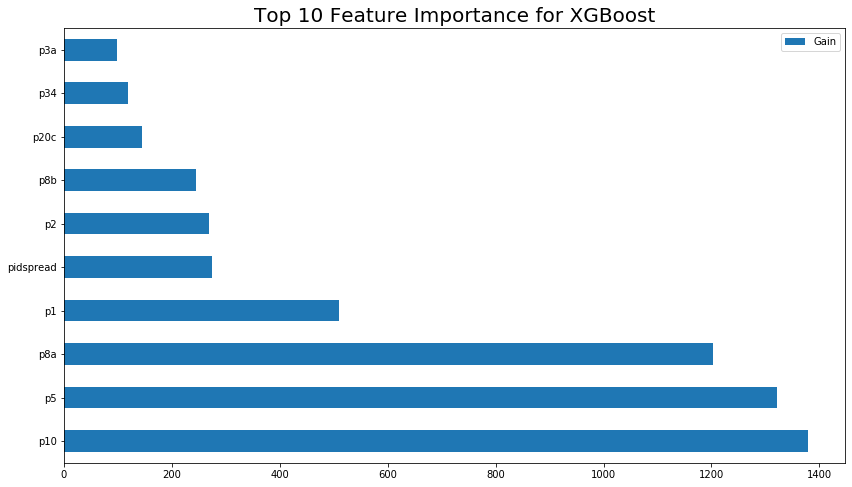

In [34]:
# display horizontal bar chart
gain_importance.plot(kind='barh', figsize=(14,8))
plt.title('Top 10 Feature Importance for XGBoost', fontsize=20)
plt.yticks(np.arange(10), ['p10', 'p5', 'p8a', 'p1', 'pidspread', 'p2', 'p8b', 'p20c', 'p34', 'p3a'])

In [90]:
train_new = train.drop(columns=['id'])
y_train = train_new['label'].to_list()
X_train = train_new.drop(columns=['label'])
oversample = SMOTE(sampling_strategy=0.1,
                          k_neighbors=5)
X_train, y_train = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_train

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,3,2,3,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,4.000000,0.0,0.0,0.0
1,1,1,1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,2.000000,0.0,0.0,0.0
2,1,1,1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,-5.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3,1,1,1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,4.000000,0.0,0.0,0.0
4,1,1,1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311995,1,1,1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
311996,42,5,37,1.47518,0.0,0.0,0.0,0.0,0.0,0.0,...,2.033093,0.0,0.0,-2.847122,0.0,0.0,2.491727,0.0,0.0,0.0
311997,2,1,2,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,4.0,0.0,0.0
311998,2,2,2,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,-11.956333,0.0,0.0,0.000000,0.0,0.0,0.0


In [91]:
# fit model
xg = xgb.XGBRFClassifier(random_state=42)
xg.fit(X_train, y_train)
goldstandard_new = goldstandard.drop(columns=['id'])
y_gold = goldstandard_new['label'].to_list()
X_gold = goldstandard_new.drop(columns=['label'])
X_gold

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,3,2,3,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,2.333333,0.0,0.0,0.0
1,3,2,3,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0
2,1,1,1,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0
3,1,1,1,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,2.0,0.0
4,1,1,1,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,2.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,2,1,2,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,8.500000,0.0,0.0,0.0
135,3,3,3,5.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,-4.666667,0,5.0,0.000000,0.0,0.0,0.0
136,5,2,5,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0
137,2,1,2,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,2.000000,0.0,0.0,0.0


In [92]:
# predict
predictions =xg.predict(X_gold)

In [93]:
# get metrics
print(f'Precision {precision_score(y_gold, predictions)}, Recall {recall_score(y_gold, predictions)}, F1 {f1_score(y_gold, predictions)}')

Precision 0.16666666666666666, Recall 0.2, F1 0.1818181818181818


In [94]:
# flip labels
conf_matrix = confusion_matrix(y_gold, predictions)
precision = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
recall = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
f1 = (2*precision*recall)/(precision+recall)
print(f'Precision {precision}, Recall {recall}, F1 {f1}')

Precision 0.9699248120300752, Recall 0.9626865671641791, F1 0.9662921348314607


## 2.4 Random Forest

In [5]:
rf = RandomForestClassifier(random_state=42)
util_two_class.cross_validation(folder_validation, folder_train,
                ['id'],
                rf, sample=True)

[[1235668   64342]
 [  18726    4120]]
Precision 0.06017936957728375 and Recall 0.18033791473343255 and F1 0.09024400928724756
----------------------------------
[[1229620   70390]
 [  18672    4174]]
Precision 0.05597875650447937 and Recall 0.1827015670139193 and F1 0.085699620162201
----------------------------------
[[1246146   53864]
 [  19582    3264]]
Precision 0.0571348550623162 and Recall 0.142869648953865 and F1 0.08162652862180209
----------------------------------
[[1240934   59076]
 [  18840    4006]]
Precision 0.06350464474810565 and Recall 0.17534798214129388 and F1 0.09324085280700121
----------------------------------
[[1239729   60283]
 [  19302    3547]]
Precision 0.055569481435061886 and Recall 0.15523655302201408 and F1 0.0818421993793191
----------------------------------
---------------------
Overall Precision: 0.05847342146544937
Overall Recall: 0.16729873317290497
Overall F1: 0.0865306420515142
---------------------
Negative Precision: 0.984871359556926
Negative

In [38]:
train_new = train.drop(columns=['id'])
y_train = train_new['label'].to_list()
X_train = train_new.drop(columns=['label'])
oversample = SMOTE(sampling_strategy=0.1,
                          k_neighbors=5)
X_train, y_train = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_train

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,18,2,8,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,-11.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
1,1,1,1,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
2,2,1,2,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,5.000000,0.000000,0.0,0.0
3,1,1,1,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
4,2,2,1,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,-4.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311995,2,1,2,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
311996,3,2,3,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,4.000000,0.000000,0.0,0.0
311997,1,1,1,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,6.000000,0.000000,0.0,0.0
311998,89,12,72,2.060177,-3.446018,0.0,0.361061,0.0,0.0,0.0,...,0.0,0.0,0.0,-6.699116,0.0,0.0,10.538644,7.699116,0.0,0.0


In [39]:
# fit model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
goldstandard_new = goldstandard.drop(columns=['id'])
y_gold = goldstandard_new['label'].to_list()
X_gold = goldstandard_new.drop(columns=['label'])
X_gold

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,3,2,3,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,2.333333,0.0,0.0,0.0
1,3,2,3,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0
2,1,1,1,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0
3,1,1,1,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,2.0,0.0
4,1,1,1,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,2.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,2,1,2,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,8.500000,0.0,0.0,0.0
135,3,3,3,5.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,-4.666667,0,5.0,0.000000,0.0,0.0,0.0
136,5,2,5,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0
137,2,1,2,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,2.000000,0.0,0.0,0.0


In [40]:
# predict
predictions =rf.predict(X_gold)

In [41]:
# get metrics
print(f'Precision {precision_score(y_gold, predictions)}, Recall {recall_score(y_gold, predictions)}, F1 {f1_score(y_gold, predictions)}')

Precision 0.23076923076923078, Recall 0.6, F1 0.33333333333333337


In [42]:
# flip labels
conf_matrix = confusion_matrix(y_gold, predictions)
precision = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
recall = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
f1 = (2*precision*recall)/(precision+recall)
print(f'Precision {precision}, Recall {recall}, F1 {f1}')

Precision 0.9841269841269841, Recall 0.9253731343283582, F1 0.9538461538461538


## 2.5 MLP Classifier

In [6]:
nnet = MLPClassifier(random_state=42)
util_two_class.cross_validation(folder_validation, folder_train,
                ['id'],
                nnet, sample=True)

[[1193013  106997]
 [  16266    6580]]
Precision 0.05793426485996284 and Recall 0.28801540751116167 and F1 0.09646467237929088
----------------------------------
[[1132688  167322]
 [  14399    8447]]
Precision 0.04805739351080111 and Recall 0.36973649654206425 and F1 0.08505903380912821
----------------------------------
[[1211918   88092]
 [  17352    5494]]
Precision 0.058705361913106664 and Recall 0.24047973387026175 and F1 0.0943726810498832
----------------------------------
[[1188176  111834]
 [  15961    6885]]
Precision 0.05799408687741642 and Recall 0.301365665762059 and F1 0.09726980538975029
----------------------------------
[[1216153   83859]
 [  17380    5469]]
Precision 0.061223804406233207 and Recall 0.23935401986957855 and F1 0.09750661900389562
----------------------------------
---------------------
Overall Precision: 0.05678298231350405
Overall Recall: 0.28779026471102503
Overall F1: 0.09413456232638964
---------------------
Negative Precision: 0.986507180387609
Ne

In [44]:
train_new = train.drop(columns=['id'])
y_train = train_new['label'].to_list()
X_train = train_new.drop(columns=['label'])
oversample = SMOTE(sampling_strategy=0.1,
                          k_neighbors=5)
X_train, y_train = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_train

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,360,20,229,5.4,-2.0,0.0,3.0,0.0,0.0,0.0,...,2.0,0.0,2.0,-4.0,0.0,4.0,3.000000,4.0,0.0,0.0
1,4,3,3,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,0.0
4,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311995,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
311996,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
311997,16,1,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.976442,0.0,0.0,0.0
311998,18,2,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.307763,0.0,0.0,0.0


In [45]:
# fit model
nnet = MLPClassifier(random_state=42)
nnet.fit(X_train, y_train)
goldstandard_new = goldstandard.drop(columns=['id'])
y_gold = goldstandard_new['label'].to_list()
X_gold = goldstandard_new.drop(columns=['label'])
X_gold

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,3,2,3,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,2.333333,0.0,0.0,0.0
1,3,2,3,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0
2,1,1,1,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0
3,1,1,1,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,2.0,0.0
4,1,1,1,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,2.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,2,1,2,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,8.500000,0.0,0.0,0.0
135,3,3,3,5.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,-4.666667,0,5.0,0.000000,0.0,0.0,0.0
136,5,2,5,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0
137,2,1,2,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,2.000000,0.0,0.0,0.0


In [46]:
# predict
predictions =nnet.predict(X_gold)

In [47]:
# get metrics
print(f'Precision {precision_score(y_gold, predictions)}, Recall {recall_score(y_gold, predictions)}, F1 {f1_score(y_gold, predictions)}')

Precision 0.0, Recall 0.0, F1 0.0


In [48]:
# flip labels
conf_matrix = confusion_matrix(y_gold, predictions)
precision = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
recall = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
f1 = (2*precision*recall)/(precision+recall)
print(f'Precision {precision}, Recall {recall}, F1 {f1}')

Precision 0.9609375, Recall 0.917910447761194, F1 0.9389312977099238


## 2.6 Decision Tree Classifier

In [7]:
dt = DecisionTreeClassifier(random_state=42)
util_two_class.cross_validation(folder_validation, folder_train,
                ['id'],
                dt, sample=True)

[[1205850   94160]
 [  18382    4464]]
Precision 0.04526281635301752 and Recall 0.19539525518690362 and F1 0.07349962953815757
----------------------------------
[[1191064  108946]
 [  17872    4974]]
Precision 0.0436622191011236 and Recall 0.21771863783594503 and F1 0.07273737624848281
----------------------------------
[[1227084   72926]
 [  19269    3577]]
Precision 0.04675633635282277 and Recall 0.15657007791298258 and F1 0.07200877713917604
----------------------------------
[[1202975   97035]
 [  18098    4748]]
Precision 0.04664826149749958 and Recall 0.20782631532872275 and F1 0.07619414422004508
----------------------------------
[[1214864   85148]
 [  18886    3963]]
Precision 0.04447262403070328 and Recall 0.1734430390826732 and F1 0.07079314040728832
----------------------------------
---------------------
Overall Precision: 0.045360451467033346
Overall Recall: 0.19019066506944543
Overall F1: 0.07304661351062998
---------------------
Negative Precision: 0.9849224251251657
N

In [49]:
train_new = train.drop(columns=['id'])
y_train = train_new['label'].to_list()
X_train = train_new.drop(columns=['label'])
oversample = SMOTE(sampling_strategy=0.1,
                          k_neighbors=5)
X_train, y_train = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_train

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-5.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,3,2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.000000,0.0,0.0,0.000000
4,5,4,5,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311995,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.000000,0.0,0.0,0.000000
311996,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-14.0,0.0,0.0,0.000000,0.0,0.0,0.000000
311997,5,2,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.075921,0.0,0.0,0.000000
311998,3,2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,5.0,3.503576


In [50]:
# fit model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
goldstandard_new = goldstandard.drop(columns=['id'])
y_gold = goldstandard_new['label'].to_list()
X_gold = goldstandard_new.drop(columns=['label'])
X_gold

,frequency,pidspread,pldspread,p1,p10,p11,p12a,p12b,p12c,p13,...,p4,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d
0,3,2,3,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,2.333333,0.0,0.0,0.0
1,3,2,3,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0
2,1,1,1,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0
3,1,1,1,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,2.0,0.0
4,1,1,1,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,2.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,2,1,2,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,8.500000,0.0,0.0,0.0
135,3,3,3,5.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,-4.666667,0,5.0,0.000000,0.0,0.0,0.0
136,5,2,5,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0
137,2,1,2,0.0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0.000000,0,0.0,2.000000,0.0,0.0,0.0


In [51]:
# predict
predictions = dt.predict(X_gold)

In [52]:
# get metrics
print(f'Precision {precision_score(y_gold, predictions)}, Recall {recall_score(y_gold, predictions)}, F1 {f1_score(y_gold, predictions)}')

Precision 0.15, Recall 0.6, F1 0.24


In [53]:
# flip labels
conf_matrix = confusion_matrix(y_gold, predictions)
precision = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
recall = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
f1 = (2*precision*recall)/(precision+recall)
print(f'Precision {precision}, Recall {recall}, F1 {f1}')

Precision 0.9831932773109243, Recall 0.8731343283582089, F1 0.924901185770751


## 3. Sums

In [8]:
# get folder name
folder_name = '/path/to/9_FINAL/data/machine_learning/two_class/distance_prepared/validation/cross_validation/sum/val_fold_'
count_folder = '/path/to/9_FINAL/data/machine_learning/count_based/cross_validation/training_SMOTE/training_'

In [10]:
# loop through all folders
for i in range(0,5):
    
    normal_distribution_data = pd.DataFrame()
    
    # loop through all but current index and get fraction of data
    for j in range(0,5):
        
        # get training fold from count based features
        count_folder_specific = count_folder + str(i) + '.csv'
        counts = pd.read_csv(count_folder_specific, sep=";")
        counts = counts.id.to_list()
        print(f'Length of Counts {len(counts)}')
        
        # get ids of validation fold
        validation_data_folder = folder_name + str(j) + '.csv'
        validation_data = pd.read_csv(validation_data_folder, sep=";")
        
        # get validation data with overlap with counts
        validation_data = validation_data[validation_data.id.isin(counts)]
        
        # stack with normal_distribution_data
        normal_distribution_data = pd.concat([normal_distribution_data,
                                             validation_data])
        print(len(normal_distribution_data))
        
    # shuffle data
    normal_distribution_data = normal_distribution_data.sample(frac=1).reset_index(drop=True)
    print(normal_distribution_data.head())
    print(len(normal_distribution_data))
    print('------------------------------------')
    
    # export data
    normal_distribution_data.to_csv('/path/to/9_FINAL/data/machine_learning/two_class/distance_prepared/validation/cross_validation/sum/train_SMOTE/train_' + str(i) + '.csv',
                                   sep=";", index=False)
    

Length of Counts 1058289
0
Length of Counts 1058289
264572
Length of Counts 1058289
529144
Length of Counts 1058289
793716
Length of Counts 1058289
1058289
          id  frequency  pidspread  pldspread  label    p1   p10  p11  p12a  \
0  288337311       3991         40       2456      0  13.0 -19.0  6.0  13.0   
1  382939640          1          1          1      0   0.0   0.0  0.0   0.0   
2  484996655          2          1          2      0   0.0   0.0  0.0   0.0   
3  244738275          8          5          8      0   0.0   0.0  0.0   0.0   
4   58154522          1          1          1      0   0.0   0.0  0.0   0.0   

   p12b  ...   p4  p42  p43    p5   p6   p7    p8a   p8b   p8c  p8d  
0   0.0  ...  8.0  0.0  8.0 -44.0  0.0  8.0  123.0  40.0  10.0  9.0  
1   0.0  ...  0.0  0.0  0.0   0.0  0.0  0.0    0.0   0.0   0.0  0.0  
2   0.0  ...  0.0  0.0  0.0   0.0  0.0  0.0    0.0   0.0   0.0  0.0  
3   0.0  ...  0.0  0.0  0.0 -10.0  0.0  0.0    3.0   0.0   0.0  0.0  
4   0.0  ...  0.0  

In [18]:
# folder train
folder_train = '/path/to/9_FINAL/data/machine_learning/two_class/distance_prepared/validation/cross_validation/sum/train_SMOTE/train_'

In [19]:
# folder validation
folder_validation = '/path/to/9_FINAL/data/machine_learning/two_class/distance_prepared/validation/cross_validation/sum/val_fold_'

## 3.2 Naive Bayes

In [22]:
nb = GaussianNB()
util_two_class.cross_validation(folder_validation, folder_train,
                ['id'],
                nb, sample=True)

[[1257136   42874]
 [  21665    1181]]
Precision 0.026807399841107707 and Recall 0.05169395080101549 and F1 0.03530589976233539
----------------------------------
[[1256251   43759]
 [  21774    1072]]
Precision 0.023912025161160803 and Recall 0.04692287490151449 and F1 0.03167989124813452
----------------------------------
[[1262150   37860]
 [  21844    1002]]
Precision 0.025783541763161957 and Recall 0.04385888120458724 and F1 0.03247552991508394
----------------------------------
[[1241158   58852]
 [  21622    1224]]
Precision 0.02037419268926027 and Recall 0.053576118357699376 and F1 0.029521719206000815
----------------------------------
[[1262917   37095]
 [  21905     944]]
Precision 0.024816635558242855 and Recall 0.04131471836841875 and F1 0.031007751937984496
----------------------------------
---------------------
Overall Precision: 0.02433875900258672
Overall Recall: 0.04747330872664707
Overall F1: 0.03199815841390784
---------------------
Negative Precision: 0.9829673979